In [1]:
from torch.nn import Sequential, Linear, SiLU, ModuleList
from torch_geometric.nn import MessagePassing, MLP, AttentionalAggregation, MaxAggregation
from torch_geometric.nn import PointNetConv, PositionalEncoding
import torch

import torch
from torch_cluster import knn_graph, fps


class PointNetEncoder(torch.nn.Module):
    def __init__(self, zdim):
        super().__init__()
        self.conv1 = PointNetConv(
            local_nn=MLP([3 + 3, 32], act=SiLU(), plain_last=True), 
            global_nn=SiLU(), 
            aggr=MaxAggregation()
        )
        self.conv2 = PointNetConv(
            local_nn=MLP([32 + 3, 32], act=SiLU(), plain_last=True), 
            global_nn=SiLU(), 
            aggr=MaxAggregation()
        )
        self.aggr = MaxAggregation()
        self.net = Linear(32, zdim)

    def forward(self, pos: torch.Tensor, batch: torch.Tensor):
        h: torch.Tensor
        edge_index = knn_graph(pos, k=16, batch=batch, loop=True)
        h = self.conv1(x=pos, pos=pos, edge_index=edge_index)

        index = fps(pos, batch, ratio=0.5)
        h, pos, batch = h[index], pos[index], batch[index]
        edge_index = knn_graph(pos, k=16, batch=batch, loop=True)
        h = self.conv2(x=h, pos=pos, edge_index=edge_index)

        h = self.aggr(h, batch)  # [batch_size, hidden_channels]
        return self.net(h)
    

class ConcatSquashLinear(torch.nn.Module):
    def __init__(self, dim_in, dim_out, dim_ctx):
        super(ConcatSquashLinear, self).__init__()
        self._layer = Linear(dim_in, dim_out)
        self._hyper_bias = Linear(dim_ctx, dim_out, bias=False)
        self._hyper_gate = Linear(dim_ctx, dim_out)

    def forward(self, x: torch.Tensor, ctx: torch.Tensor, batch: torch.Tensor):
        gate: torch.Tensor = torch.sigmoid(self._hyper_gate(ctx))
        bias: torch.Tensor = self._hyper_bias(ctx)
        ret: torch.Tensor = self._layer(x) * gate[batch] + bias[batch]
        return ret


class PointwiseNet(torch.nn.Module):
    def __init__(self, dim_ctx):
        super().__init__()
        self.embedding = PositionalEncoding(dim_ctx)
        self.net = ModuleList([
            ConcatSquashLinear(3, 128, dim_ctx + dim_ctx),
            ConcatSquashLinear(128, 256, dim_ctx + dim_ctx),
            ConcatSquashLinear(256, 512, dim_ctx + dim_ctx),
            ConcatSquashLinear(512, 256, dim_ctx + dim_ctx),
            ConcatSquashLinear(256, 128, dim_ctx + dim_ctx),
        ])
        self.out = ConcatSquashLinear(128, 3, dim_ctx + dim_ctx)

    def forward(self, x: torch.Tensor, ctx: torch.Tensor, t: torch.Tensor, batch: torch.Tensor):
        ctx2 = self.embedding(t)
        ctx = torch.cat([ctx, ctx2], dim=-1)
        
        out: torch.Tensor = x
        for layer in self.net:
            out = layer(out, ctx, batch)
            out = torch.nn.functional.silu(out)

        out = self.out(out, ctx, batch)
        return x + out



In [2]:
from torch_geometric.datasets import GeometricShapes
from torch_geometric.transforms import NormalizeScale, SamplePoints, Compose

transform = Compose([NormalizeScale(), SamplePoints(1024)])
dataset = GeometricShapes(root='data/GeometricShapes', transform=transform)
print(dataset)

GeometricShapes(40)


In [3]:
import torch_geometric.transforms as T
from torch_geometric.datasets import ShapeNet
from torch_geometric.loader import DataLoader


path = "data/ShapeNet"
category = 'Airplane' 
transform = T.Compose([
    T.FixedPoints(1024),
    # T.RandomRotate(15, axis=0),
    # T.RandomRotate(15, axis=1),
    # T.RandomRotate(15, axis=2),
])
pre_transform = T.NormalizeScale()
train_dataset = ShapeNet(path, category, split='trainval', transform=transform, pre_transform=pre_transform)
test_dataset = ShapeNet(path, category, split='test', transform=transform, pre_transform=pre_transform)
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=24, shuffle=False)


In [4]:
import numpy as np

class VarianceSchedule(torch.nn.Module):
    def __init__(self, num_steps, beta_1, beta_T):
        super().__init__()
        self.num_steps = num_steps
        self.beta_1 = beta_1
        self.beta_T = beta_T

        betas = torch.linspace(beta_1, beta_T, steps=num_steps)
        betas = torch.cat([torch.zeros([1]), betas], dim=0)     # Padding

        alphas = 1 - betas
        log_alphas = torch.log(alphas)
        for i in range(1, log_alphas.size(0)):  # 1 to T
            log_alphas[i] += log_alphas[i - 1]
        alpha_bars = log_alphas.exp()

        sigmas_flex = torch.sqrt(betas)
        sigmas_inflex = torch.zeros_like(sigmas_flex)
        for i in range(1, sigmas_flex.size(0)):
            sigmas_inflex[i] = ((1 - alpha_bars[i-1]) / (1 - alpha_bars[i])) * betas[i]
        sigmas_inflex = torch.sqrt(sigmas_inflex)

        self.betas: torch.Tensor
        self.alphas: torch.Tensor
        self.alpha_bars: torch.Tensor
        self.sigmas_flex: torch.Tensor
        self.sigmas_inflex: torch.Tensor
        self.register_buffer('betas', betas)
        self.register_buffer('alphas', alphas)
        self.register_buffer('alpha_bars', alpha_bars)
        self.register_buffer('sigmas_flex', sigmas_flex)
        self.register_buffer('sigmas_inflex', sigmas_inflex)

    def uniform_sample_t(self, batch_size):
        ts = np.random.choice(np.arange(1, self.num_steps+1), batch_size)
        return ts.tolist()

    def get_sigmas(self, t, flexibility):
        assert 0 <= flexibility and flexibility <= 1
        sigmas = self.sigmas_flex[t] * flexibility + self.sigmas_inflex[t] * (1 - flexibility)
        return sigmas

In [5]:
class Model(torch.nn.Module):
    def __init__(self, zdim, num_steps, beta_1, beta_T):
        super().__init__()
        self.encoder = PointNetEncoder(zdim)
        self.decoder = PointwiseNet(zdim)
        self.schedule = VarianceSchedule(num_steps, beta_1, beta_T)

    def encode(self, pos: torch.Tensor, batch: torch.Tensor):
        return self.encoder(pos, batch)
    
    def decode(self, shape: tuple, ctx: torch.Tensor, batch: torch.Tensor, flex: float=0.0):
        x_t = torch.randn(shape).to(ctx.device)
        batch_size = int(batch.max() + 1)

        for t in range(self.schedule.num_steps, 0, -1):
            alpha = self.schedule.alphas[t]
            alpha_bar = self.schedule.alpha_bars[t]
            sigma = self.schedule.get_sigmas(t, flex)

            c0 = 1.0 / torch.sqrt(alpha)
            c1 = (1 - alpha) / torch.sqrt(1 - alpha_bar)

            beta = self.schedule.betas[t].repeat(batch_size).view(-1, 1)
            e_theta = self.decoder(x_t, t=beta, ctx=ctx, batch=batch)
            
            z = torch.randn_like(x_t) if t > 1 else torch.zeros_like(x_t)
            x_t = c0 * (x_t - c1 * e_theta) + sigma * z

        return x_t
    

    def forward(self, pos: torch.Tensor, batch: torch.Tensor):
        z: torch.Tensor = self.encoder(pos, batch)
        batch_size = z.size(0)
 
        t = self.schedule.uniform_sample_t(batch_size)
        alpha_bar = self.schedule.alpha_bars[t]
        beta = self.schedule.betas[t]

        c0 = torch.sqrt(alpha_bar)       
        c1 = torch.sqrt(1 - alpha_bar)   
        c0, c1 = c0[batch].view(-1, 1), c1[batch].view(-1, 1)

        e_rand = torch.randn_like(pos)
        e_theta = self.decoder(c0 * pos + c1 * e_rand, t=beta, ctx=z, batch=batch)

        return e_theta, e_rand

In [6]:
from pytorch3d.loss import chamfer_distance
from torch_geometric.utils import to_dense_batch
from torch import nn

class CDLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, target, batch, reduction='mean'):
        pred, target = to_dense_batch(pred, batch)[0], to_dense_batch(target, batch)[0]
        return chamfer_distance(pred, target, batch_reduction=reduction)[0]
    

In [7]:
def get_data_iterator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, data in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

In [8]:
def get_linear_scheduler(optimizer, start_epoch, end_epoch, start_lr, end_lr):
    def lr_func(epoch):
        if epoch <= start_epoch:
            return 1.0
        elif epoch <= end_epoch:
            total = end_epoch - start_epoch
            delta = epoch - start_epoch
            frac = delta / total
            return (1-frac) * 1.0 + frac * (end_lr / start_lr)
        else:
            return end_lr / start_lr
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_func)

In [9]:
import matplotlib.pyplot as plt
from torch_geometric.utils import to_dense_batch
import math


def visualize_points(pos, c=None):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c='blue' if c is None else c, s=3)
    plt.show()

def visualize_batched_points(pos, batch, index, c=None):
    tg, _ = to_dense_batch(pos, batch)
    tg = tg[index]
    visualize_points(tg.cpu())


def visualize_batch_results(pos, newpos, batch, max_in_row=5):
    pos, _ = to_dense_batch(pos, batch)
    newpos, _ = to_dense_batch(newpos, batch)
    n = pos.size(0)

    num_rows = math.ceil(n / max_in_row)
    num_cols = min(n, max_in_row)
    print(num_rows, num_cols)

    fig = plt.figure(figsize=(num_cols * 4, num_rows * 4))
    for i in range(n):
        ax = fig.add_subplot(2 * num_rows, num_cols, i+1, projection='3d')
        pc = pos[i].cpu()
        ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c='red', s=3)
        ax.set_aspect('equal', adjustable='datalim')

    for i in range(n):
        ax = fig.add_subplot(2 * num_rows, num_cols, i+num_cols * num_rows + 1, projection='3d')
        pc = newpos[i].cpu()
        ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c='blue', s=3)
        ax.set_aspect('equal', adjustable='datalim')

    return fig


In [10]:
import logging
from logging.handlers import MemoryHandler
import os
import time


def get_logger(name, log_dir=None):
    logger = logging.getLogger(name)
    logger.setLevel(logging.DEBUG)
    formatter = logging.Formatter('[%(asctime)s::%(name)s::%(levelname)s] %(message)s')

    stream_handler = logging.StreamHandler()
    stream_handler.setLevel(logging.DEBUG)
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)

    if log_dir is not None:
        file_handler = logging.FileHandler(os.path.join(log_dir, f'{name}.log'))
        file_handler.setLevel(logging.INFO)
        file_handler.setFormatter(formatter)
        memory_handler = MemoryHandler(10, flushLevel=logging.ERROR, target=file_handler, flushOnClose=True)

        logger.addHandler(memory_handler)

    return logger


def get_new_log_dir(root='./logs', postfix='', prefix=''):
    log_dir = os.path.join(root, prefix + time.strftime('%Y_%m_%d__%H_%M_%S', time.localtime()) + postfix)
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(os.path.join(log_dir, 'checkpoints'), exist_ok=True)
    os.makedirs(os.path.join(log_dir, 'samples'), exist_ok=True)
    return log_dir


In [11]:
log_dir = get_new_log_dir(prefix='diffusion_')

train_logger = get_logger('train', log_dir=log_dir)
val_logger = get_logger('val', log_dir=log_dir)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(zdim=train_dataset.num_classes, num_steps=1000, beta_1=1e-4, beta_T=0.02).to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()  # Define loss criterion.
cd = CDLoss()


In [12]:
@torch.no_grad()
def validate_loss(it):
    all_loss = 0
    for i, data in enumerate(test_loader):
        model.eval()
        data = data.to(device)
        
        z = model.encode(data.pos, data.batch)
        recons = model.decode(data.pos.size(), z, data.batch)
        loss = cd(recons, data.pos, data.batch, reduction='sum')

        val_logger.info("Validation:: Iteration: {}, Loss: {}".format(i, loss.item()))
        all_loss += loss.item()

        if i == 0:
            fig = visualize_batch_results(data.pos, recons, data.batch)
            path = os.path.join(log_dir, 'samples', 'sample_{}.png'.format(it))
            fig.savefig(path)
            val_logger.info("Validation:: Saved sample image to {}".format(path))
    
    val_logger.info("Validation:: Average Loss: {}".format(all_loss / len(test_loader.dataset))) # type: ignore
    return all_loss / len(test_loader.dataset) # type: ignore

    

def train():
    ma_loss = 0
    val_loss = validate_loss(0)
    for i, data in enumerate(get_data_iterator(train_loader), 1):
        optimizer.zero_grad()  # Clear gradients.
        model.train() 
        data = data.to(device)
        
        e_theta, e_rand = model(data.pos, data.batch)  # Forward pass.
        loss = criterion(e_theta, e_rand)  # Loss computation.
        
        loss.backward()  # Backward pass.
        optimizer.step()  # Update model parameters.
        
        ma_loss = 2 / (i + 1) * (loss.item() - ma_loss) + ma_loss
        if i % 10000 == 0:
            val_loss = validate_loss(i)
            
            train_logger.info("Train:: Saving epoch {} with loss {}".format(i, val_loss))
            torch.save({
                'epoch': i,
                'model_state_dict': model.state_dict(),
                'model_buffers': model.buffers(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, os.path.join(log_dir, 'checkpoints', 'checkpoint_{}.pt'.format(i)))
        
        train_logger.info("Train:: Iteration: {}, Loss: {}, MA Loss: {}".format(i, loss.item(), ma_loss))


[,586015095::val::INFO] Validation:: Iteration: 0, Loss: 6.012740135192871


5 5


[,586031235::val::INFO] Validation:: Iteration: 1, Loss: 5.912974834442139
[,586044866::val::INFO] Validation:: Iteration: 2, Loss: 5.886682987213135
[,586058494::val::INFO] Validation:: Iteration: 3, Loss: 5.754562854766846
[,586072123::val::INFO] Validation:: Iteration: 4, Loss: 6.122481346130371
[,586085754::val::INFO] Validation:: Iteration: 5, Loss: 5.8978495597839355
[,586099387::val::INFO] Validation:: Iteration: 6, Loss: 6.191004753112793
[,586113022::val::INFO] Validation:: Iteration: 7, Loss: 5.940391540527344
[,586126655::val::INFO] Validation:: Iteration: 8, Loss: 5.827444076538086
[,586140285::val::INFO] Validation:: Iteration: 9, Loss: 6.011092185974121
[,586153917::val::INFO] Validation:: Iteration: 10, Loss: 5.827712059020996
[,586167547::val::INFO] Validation:: Iteration: 11, Loss: 5.815235614776611
[,586181180::val::INFO] Validation:: Iteration: 12, Loss: 5.828261852264404
[,586194812::val::INFO] Validation:: Iteration: 13, Loss: 5.9164347648620605
[,586197920::val::I

KeyboardInterrupt: 

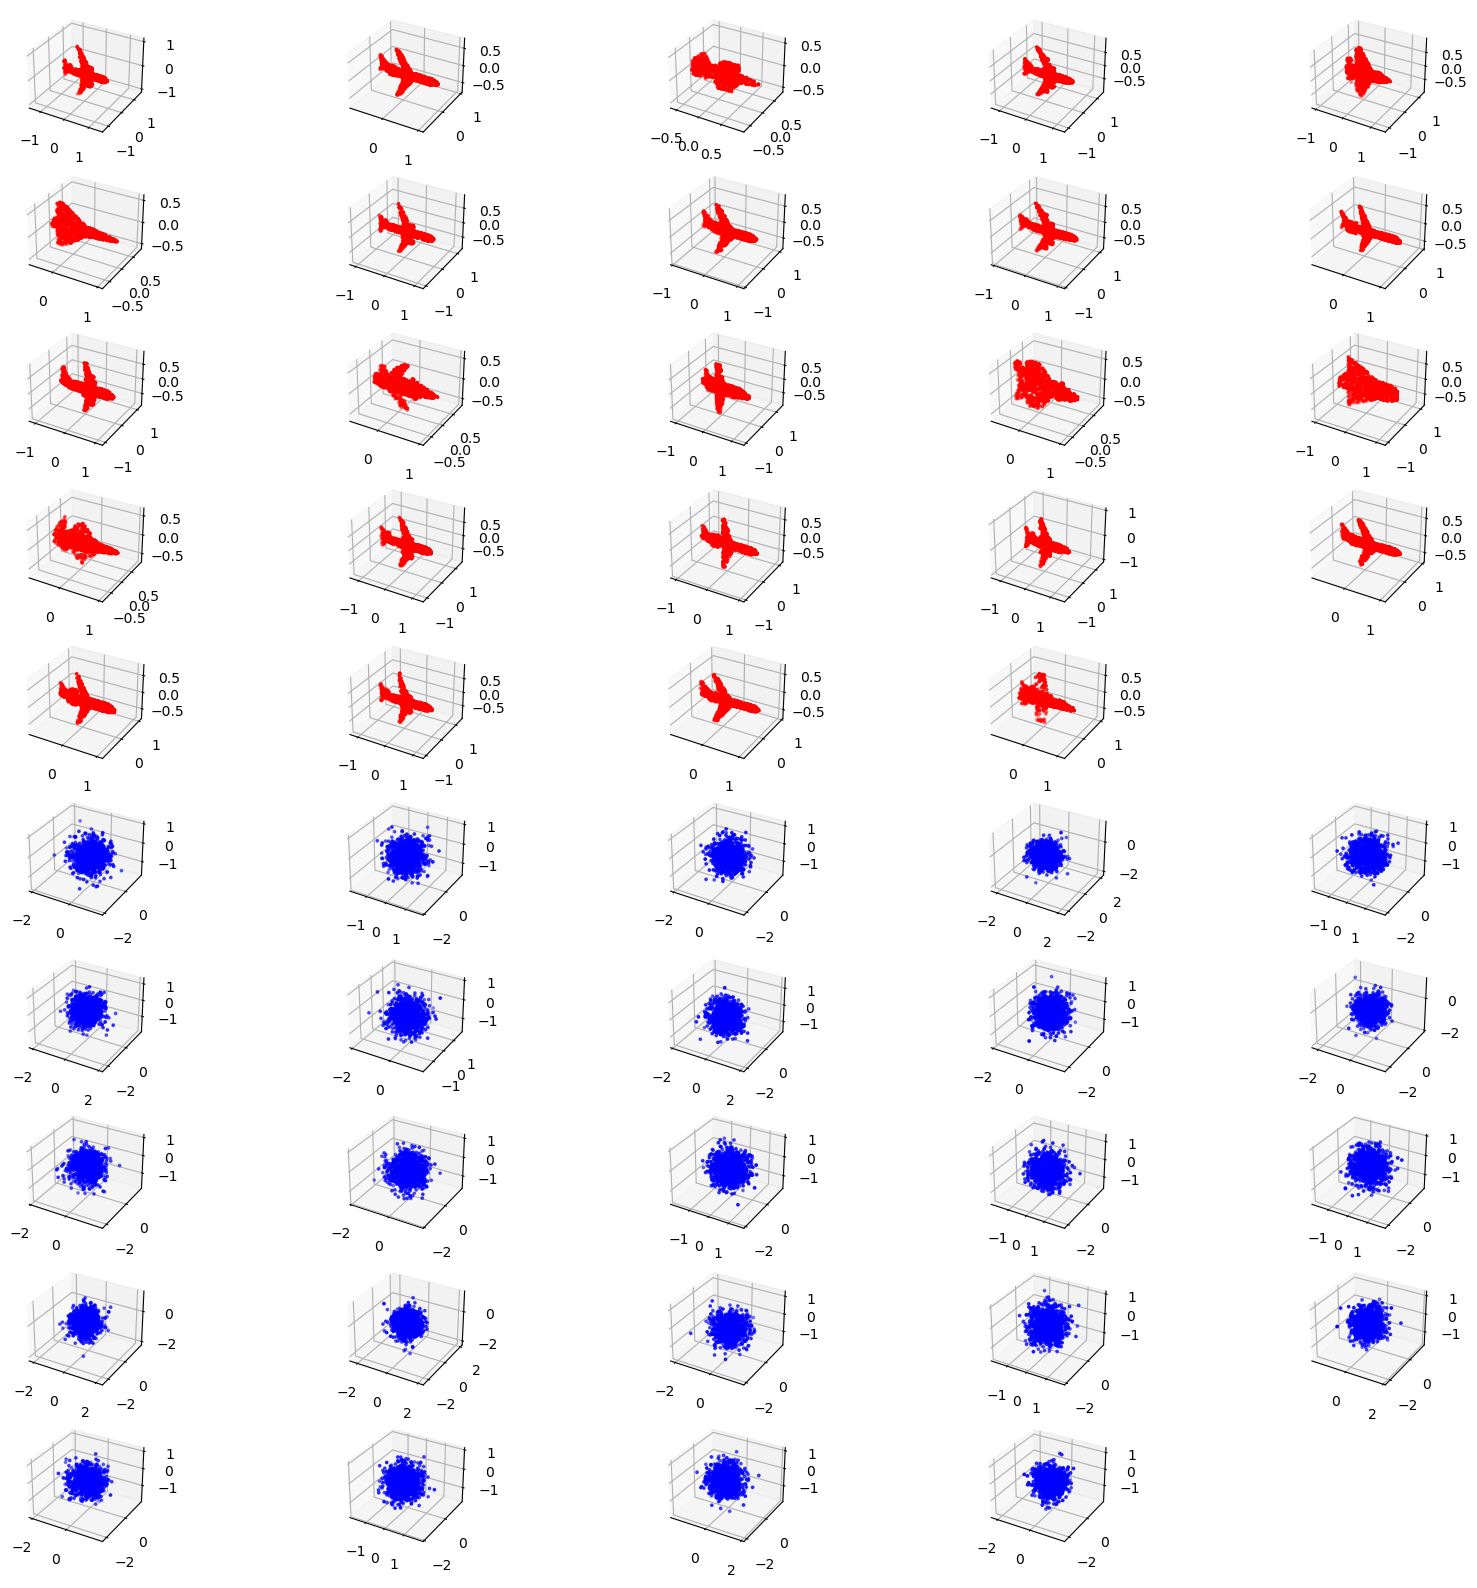

In [13]:
train()